In [22]:
import time

import numpy as np

from scipy.signal import convolve2d

import pycuda.driver as cuda
import pycuda.tools
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule

from arrayimage import ArrayInterfaceImage

from pyglet.gl import *
from pyglet import window
from pyglet import image

import matplotlib.pyplot as plt

# Introduction

On a forum, I got a discussion with 2 other people talking about the interest of GPU to simulate the Game of Life. I wanted to implement both solution and check the time to generate frames. Let's dig into it

# Game of Life

The explanation of the game is available in <a href="https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life">Wikipedia</a>.

# CPU implementation

The grid will be a Numpy Array. The idea is to loop thru all cells and check the number of neighbors. Based on that, we actualise the state of the cell. To do the count, we can use a simple nested loop but also a convolution with a 3x3 filter 

\begin{bmatrix} 
1 & 1 & 1 \\
1 & 0 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}

Let's create a Class to handle both cases

In [2]:
class GameCPU:
    def __init__(self, w, h, w_block = 32, h_block = 32, use_convolve=True):
        self.w = w
        self.h = h
        # Not required here but we need to have the same matrix size with the GPU
        self.w_block = w_block                  # useless
        self.h_block = h_block                  # useless
        self.w_grid = w // w_block              # useless
        self.w = w_block * self.w_grid          # useless
        self.h_grid = h // h_block              # useless
        self.h = h_block * self.h_grid          # useless
        self.use_convolve = use_convolve
        self.state = np.random.randint(2, size=(self.h, self.w), dtype=np.bool)
        self.filter = np.array([[1, 1, 1],[1, 0, 1],[1, 1, 1]])

    def step_simple(self):
        ###
        #This create the new state matrix but usign nested loop
        ###
        count_mat = np.zeros(shape=(self.h, self.w), dtype=np.int32)
        for row in range(self.h):
            for col in range(self.w):
                count = 0
                if col > 0:
                    count += self.state[row, col-1]
                    if row > 0:
                        count += self.state[row - 1, col-1]
                    if row < self.h - 1:
                        count += self.state[row + 1, col-1]
                if col < self.w-1:
                    count += self.state[row, col + 1]
                    if row > 0:
                        count += self.state[row - 1, col + 1]
                    if row < self.h - 1:
                        count += self.state[row + 1, col + 1]
                if row > 0:
                    count += self.state[row - 1, col]
                if row < self.h-1:
                    count += self.state[row + 1, col]
                count_mat[row, col] = count
        new_state = (count_mat == 3) | (self.state & (count_mat == 2))
        self.state = new_state
        return self.to_format()

    def step_convolve(self):
        ###
        # This create the new state matrix but usign nested loop
        ###
        count_mat = convolve2d(self.state, self.filter, mode='same', boundary='fill', fillvalue=0)
        new_state = (count_mat == 3) | (self.state & (count_mat == 2))
        self.state = new_state
        return self.to_format()

    def step(self):
        if self.use_convolve:
            return self.step_convolve()
        else:
            return self.step_simple()

    def to_format(self):
        # required for the display
        return 255 * self.state.astype(np.uint8)

# GPU implementation

We can create the same class with the use of a GPU. This will require pyCUDA library to run code on the GPU. 

<b>Note :</b> The code used for pyCUDA has been found on the Internet

In [3]:
class GameGPU:
    def __init__(self, w, h, w_block = 32, h_block = 32):
        self.w = w
        self.h = h

        # https://stackoverflow.com/questions/14504580/pycuda-blocks-and-grids-to-work-with-big-datas
        self.w_block = w_block
        self.h_block = h_block
        self.w_grid = w // w_block
        self.w = w_block * self.w_grid
        self.h_grid = h // h_block
        self.h = h_block * self.h_grid
        self.state = np.random.randint(2, size=(self.h, self.w), dtype=np.int32)

        self.mod = SourceModule("""
            __global__ void step(int *C, int *M)
            {
                int count;
                int n_x = blockDim.x * gridDim.x;
                int i = threadIdx.x + blockDim.x * blockIdx.x;
                int j = threadIdx.y + blockDim.y * blockIdx.y;
                int threadId = j*n_x+i;
                int i_left; int i_right; int j_down; int j_up;

                if(i==0) {i_left=n_x-1;} else {i_left=i-1;}
                if(i==n_x-1) {i_right=0;} else {i_right=i+1;}
                if(j==0) {j_down=n_x-1;} else {j_down=j-1;}
                if(j==n_x-1) {j_up=0;} else {j_up=j+1;}

                count = C[j*n_x+i_left] + C[j_down*n_x+i]
                        + C[j*n_x+i_right] + C[j_up*n_x+i] + C[j_up*n_x+i_left]
                        + C[j_down*n_x+i_right] + C[j_down*n_x+i_left]
                        + C[j_up*n_x+i_right];

                //A cell is "Born" if it has exactly 3 neighbours, 
                //A cell "Survives" if it has 2 or 3 living neighbours; it dies otherwise.
                if(count < 2 || count > 3) M[threadId] = 0; // cell dies
                if(count == 2) M[threadId] = C[threadId];// cell stays the same
                if(count == 3) M[threadId] = 1; // cell either stays alive, or is born
            }
        """)
        self.func = self.mod.get_function("step")


    def step(self, ):
        new_state = np.empty_like(self.state)
        state_gpu = gpuarray.to_gpu(self.state)
        new_state_gpu = gpuarray.to_gpu(new_state)
        self.func(state_gpu, new_state_gpu, block=(self.h_block, self.w_block, 1), grid=(self.h_grid, self.w_grid, 1))
        self.state = new_state_gpu.get()
        return self.to_format()

    def to_format(self):
        return 255 * self.state.astype(np.uint8)

# Rendering

For the rendering, in order to avoid framerate impact, I used pyglet to be able to get performances of OpenGL. Again in order to boost performances, the matrix, will be converted to a texture. This is done using a library : https://pypi.org/project/pygarrayimage/

The last thing to do is to create a rendering function. This one will call the next iteration of the game, convert it to a texture and display it. 

In [4]:
def render(env):
    height, width = env.h, env.w

    w = window.Window(width, height, visible=True, resizable=False)

    aii = ArrayInterfaceImage(env.to_format())

    img = aii.texture
    img.blit(0, 0, 0)
    w.flip()
    glEnable(GL_BLEND)
    glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)

    while not w.has_exit:
        w.dispatch_events()

#         start = time.time()
        arr = env.step()
#         duration = time.time() - start
#         print("Time : {:.9f} - Living Cells : {}".format(duration, arr.sum() // 255))

        aii.view_new_array(arr)
        img.blit(0, 0, 0)
        w.flip()

and let's run it

In [ ]:
w = 1920
h = 1080
env = GameGPU(w, h, w_block = 32, h_block = 32)
# env = GoL_CPU.Game(w, h, w_block = 32, h_block = 32, use_convolve=False)
render(env)

And the result is like noise :) :

<img src="GOL.png"/>

# Evaluation

Now the code is working but we would like to evaluate the benefit. To do so, we will skip the rendering part and the time the computation of n-frames to get the number of cells simulated per seconds

In [26]:
def evaluate(env, limit_frame=1000, timeout=60):
    timer = []
    frame = 0
    start = time.time()
    stop = start
    while frame < limit_frame and stop - start < timeout:
        env.step()
        print(frame, end="\r")
        stop = time.time()
        timer.append(stop - start)
        frame += 1
    return np.ediff1d(timer)

## Comparison of models @ fixed size

First let's check the time for each model to simulate an environment at a fixed size

In [38]:
n = 20
w = 32*n
h = 32*n
env = GameGPU(w, h, w_block = 32, h_block = 32)
timeGPU = evaluate(env)

env = GameCPU(w, h, w_block = 32, h_block = 32, use_convolve=False)
timeCPU_simple = evaluate(env)

env = GameCPU(w, h, w_block = 32, h_block = 32, use_convolve=True)
timeCPU_conv = evaluate(env)

Let's plot a boxplot for each models

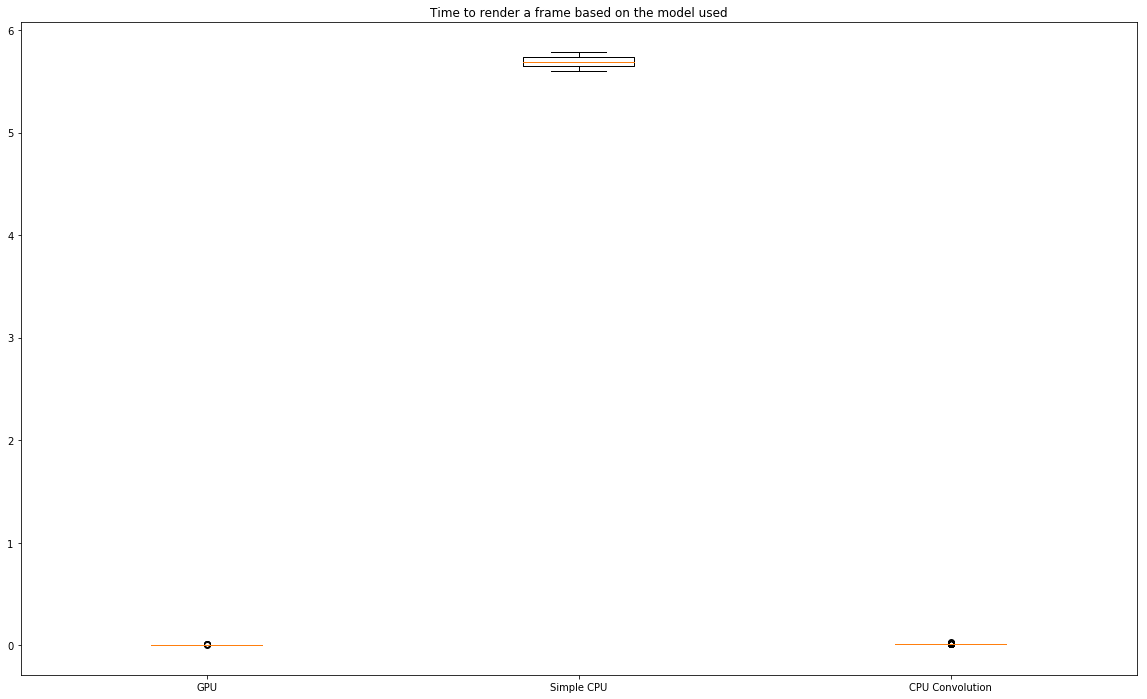

In [50]:
fig, ax = plt.subplots(figsize=(20,12))
ax.boxplot(x = [timeGPU, timeCPU_simple, timeCPU_conv], 
           labels = ['GPU', 'Simple CPU', 'CPU Convolution'])
ax.set_title("Time to render a frame based on the model used")
plt.show()

The diff is so important than we may need to use a log scale

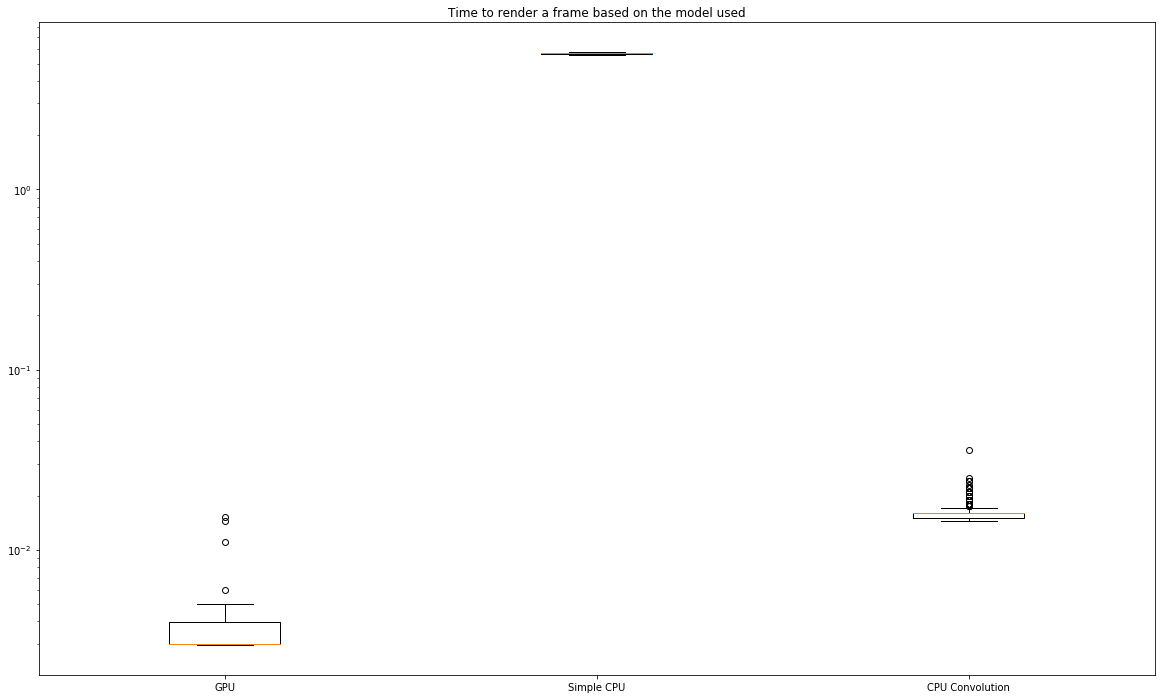

In [51]:
fig, ax = plt.subplots(figsize=(20,12))
ax.boxplot(x = [timeGPU, timeCPU_simple, timeCPU_conv], 
           labels = ['GPU', 'Simple CPU', 'CPU Convolution'])
ax.set_title("Time to render a frame based on the model used")
ax.set_yscale('log')
plt.show()

Now we can see that GPU is around 10 time faster than CPU with Convolution and 1000 time faster that simple serial CPU.

## Evolution with Frame Size

Let's now look how the time evolve with frame size. Now instead of return the diff of time between 2 frames, the code will be changed to return the time from the beginning to avoid issue with too short time.

Also, we will only focus on GPU vs CPU with Convolution

In [52]:
def evaluate(env, limit_frame=1000, timeout=60):
    timer = []
    frame = 0
    start = time.time()
    stop = start
    while frame < limit_frame and stop - start < timeout:
        env.step()
        print(frame, end="\r")
        stop = time.time()
        timer.append(stop - start)
        frame += 1
    return timer

In [70]:
evoGPU = []
evoCPU = []
sizes = [32, 64, 128, 256, 512, 768, 1024, 1536, 2048]
for n in sizes:
    print("Size  :", n)
    
    env = GameGPU(n, n, w_block = 32, h_block = 32)
    timeGPU = evaluate(env)
    evoGPU.append(timeGPU[-1] / len(timeGPU))
    
    env = GameCPU(n, n, w_block = 32, h_block = 32, use_convolve=True)
    timeCPU = evaluate(env)
    evoCPU.append(timeCPU[-1] / len(timeCPU))

Size  : 32
Size  : 64
Size  : 128
Size  : 256
Size  : 512
Size  : 768
Size  : 1024
Size  : 1536
Size  : 2048


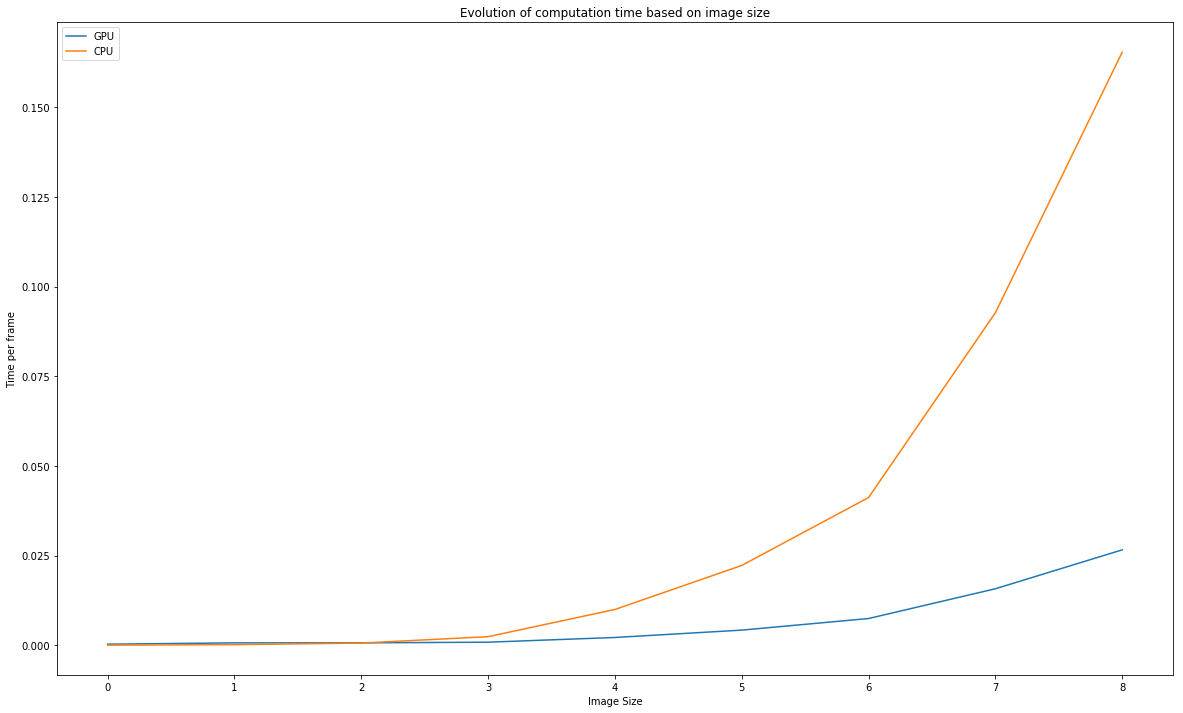

In [71]:
plt.figure(figsize=(20,12))
plt.plot(evoGPU, label="GPU")
plt.plot(evoCPU, label="CPU")
plt.title("Evolution of computation time based on image size")
plt.xlabel("Image Size")
plt.ylabel("Time per frame")
plt.legend()
plt.show()

We can also look at pixels per seconds

In [72]:
frames_GPU = len(timeGPU)
pixels_computed_GPU = 2048 * 2048 * frames_GPU
time_required_GPU = timeGPU[-1]
pixels_per_sec_GPU = pixels_computed_GPU / time_required_GPU

frames_CPU = len(timeCPU)
pixels_computed_CPU = 2048 * 2048 * frames_CPU
time_required_CPU = timeCPU[-1]
pixels_per_sec_CPU = pixels_computed_CPU / time_required_CPU

In [82]:
print("Pixels per seconds")
print("CPU : {:.2e} cells/sec".format(int(pixels_per_sec_CPU)))
print("GPU : {:.2e} cells/sec".format(int(pixels_per_sec_GPU)))

Pixels per seconds
CPU : 2.54e+07 cells/sec
GPU : 1.57e+08 cells/sec


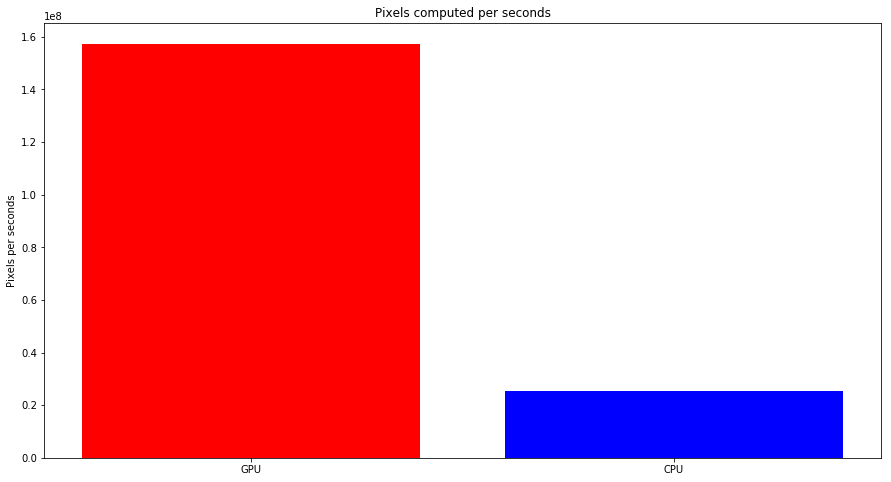

In [79]:
fig, ax = plt.subplots(figsize=(15,8))
ind = np.arange(1, 3)

gpu, cpu = plt.bar(ind, [pixels_per_sec_GPU, pixels_per_sec_CPU])
gpu.set_facecolor('r')
cpu.set_facecolor('b')
ax.set_xticks(ind)
ax.set_xticklabels(['GPU', 'CPU'])
# ax.set_ylim([0, 100])
ax.set_ylabel('Pixels per seconds')
ax.set_title('Pixels computed per seconds')
plt.show()

# Conclusion

This project was a off-topic subject I wanted to do just for learning. I was thinking that GPU was not very good at doing loops instead of matrix calculation (even if matrix calculation is based on loops). I realized that I was wrong :)

It allows me also to look again at pyglet which is not used often but provides an efficient viewer and PyCUDA even if I'm not yet understanding the complete code used in the SourceModule.